#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**
using the airbnb dataset

version 0.9 2020-09-11

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import sys
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/worldbank-immunization/clean/"
data_out = dirname + "da_case_studies/ch23-immunization-life/"
output = dirname + "da_case_studies/ch23-immunization-life/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions 
from py_helper_functions import *

In [4]:
# Import data

data = pd.read_csv(data_in + "worldbank-immunization-continents.csv")

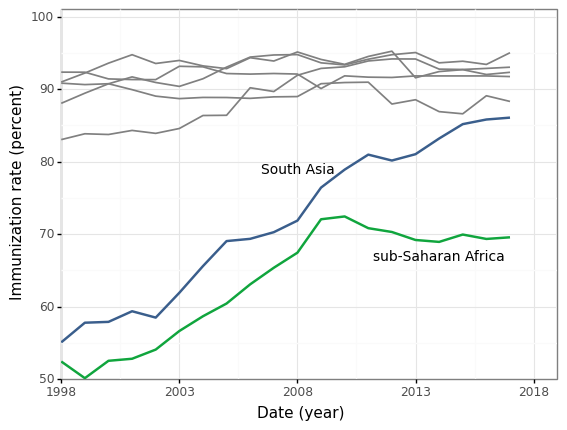

<ggplot: (315828755)>

In [5]:
p1 = (
    ggplot(data, aes(x="year", y="imm_SAS"))
    + geom_line(color=color[0], size=1)
    + geom_line(aes(x="year", y="imm_SSF"), color=color[1], size=1)
    + annotate(
        geom="text",
        x=data.loc[12, "year"] - 2,
        y=data.loc[12, "imm_SAS"],
        label="South Asia",
        size=10,
    )
    + annotate(
        geom="text",
        x=data.loc[16, "year"],
        y=data.loc[16, "imm_SSF"] - 2,
        label="sub-Saharan Africa",
        size=10,
    )
    + labs(y="Immunization rate (percent)", x="Date (year)")
    + scale_y_continuous(expand=(0, 0), breaks=range(50, 101, 10), limits=(50, 101))
    + scale_x_continuous(
        expand=(0, 0), breaks=range(1998, 2019, 5), limits=(1998, 2019)
    )
    + theme_bw()
)

for col in data.columns[1:6]:
    p1 += geom_line(aes(x="year", y=col), color="grey", size=0.7)

p1

In [6]:
for col in data.columns[8:]:
    data[col] = data[col] / 10

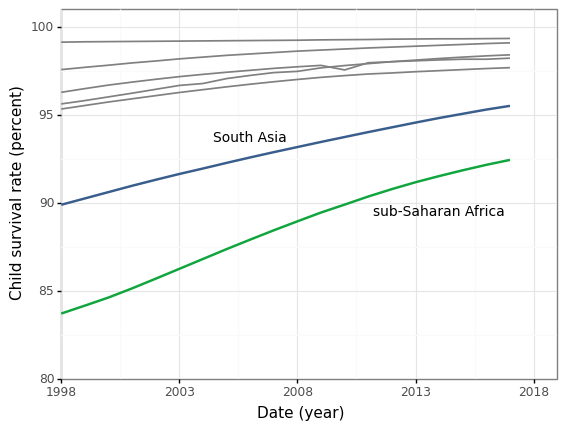

<ggplot: (315970184)>

In [7]:
p2 = (
    ggplot(data, aes(x="year", y="surv_SAS"))
    + geom_line(color=color[0], size=1)
    + geom_line(aes(x="year", y="surv_SSF"), color=color[1], size=1)
    + annotate(
        geom="text",
        x=data.loc[12, "year"] - 4,
        y=data.loc[12, "surv_SAS"],
        label="South Asia",
        size=10,
    )
    + annotate(
        geom="text",
        x=data.loc[16, "year"],
        y=data.loc[16, "surv_SSF"] - 2,
        label="sub-Saharan Africa",
        size=10,
    )
    + labs(y="Child survival rate (percent)", x="Date (year)")
    + scale_y_continuous(expand=(0, 0), breaks=range(80, 101, 5), limits=(80, 101))
    + scale_x_continuous(
        expand=(0, 0), breaks=range(1998, 2019, 5), limits=(1998, 2019)
    )
    + theme_bw()
)

for col in data.columns[8:13]:
    p2 += geom_line(aes(x="year", y=col), color="grey", size=0.7)

p2

# Regressions on countries


In [6]:
data_panel = pd.read_csv(data_in + "worldbank-immunization-panel.csv")
data_panel.describe()

,year,pop,mort,surv,imm,gdppc,lngdppc,hexp
count,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3642.000000,3642.000000,3165.000000
mean,2007.526924,35.067473,42.982847,95.701715,85.298135,16337.051802,9.042446,6.274914
std,5.759522,132.455594,45.517445,4.551744,15.738758,19070.325200,1.234401,2.878283
min,1998.000000,0.009332,2.100000,75.720000,8.000000,275.518093,5.618653,1.024978
25%,2003.000000,1.756771,9.300000,93.425000,79.000000,3114.288251,8.043756,4.321824
50%,2008.000000,7.395599,23.300000,97.670000,92.000000,9386.069679,9.146982,5.766445
75%,2013.000000,23.576856,65.750000,99.070000,96.000000,22449.101714,10.019005,7.916312
max,2017.000000,1386.395000,242.800000,99.790000,99.000000,124024.568165,11.728235,27.417822


In [7]:
data_panel = data_panel.dropna(subset=["imm","gdppc"])

In [8]:
data_panel["balanced"] = data_panel["c"].isin(
    data_panel.groupby("c")
    .agg(
        min_year=("year", min), max_year=("year", max), n_unique_years=("year", "count")
    )
    .query("(min_year == 1998)&(max_year == 2017)&(n_unique_years==20)")
    .index
)

In [27]:
data_balanced = data_panel.query("balanced == True")

In [28]:
countries_grouped = data_balanced.groupby("c")

data_balanced["lnpop"] = countries_grouped["pop"].transform(np.log)
data_balanced["d_surv"] = countries_grouped["surv"].transform("diff")
data_balanced["d_imm"] = countries_grouped["imm"].transform("diff")
data_balanced["d2_imm"] = countries_grouped["d_imm"].transform("diff")
data_balanced["d_lngdppc"] = countries_grouped["lngdppc"].transform("diff")
data_balanced["d_lnpop"] = countries_grouped["lnpop"].transform("diff")
data_balanced["avgpop"] = countries_grouped["pop"].transform("mean")

data_balanced = data_balanced.sort_values(by=["c","year"])

## Fixed Effect

In [29]:
from linearmodels import PanelOLS

In [30]:
data_balanced = data_balanced.assign(
    Year=lambda x: x["year"].astype("category")
).set_index(["c", "year"])

In [31]:
fe_lm = PanelOLS.from_formula(
    "surv ~ imm + Year + EntityEffects",
    data_balanced,
    weights=data_balanced["avgpop"],
).fit(cov_type="clustered", cluster_entity=True)

In [32]:
fe_lm.summary

Dep. Variable:,surv,R-squared:,0.7172
Estimator:,PanelOLS,R-squared (Between):,0.4249
No. Observations:,3440,R-squared (Within):,0.7172
Date:,"Thu, Apr 01 2021",R-squared (Overall):,0.4672
Time:,14:31:46,Log-likelihood,-4053.2
Cov. Estimator:,Clustered,,
,,F-statistic:,1.668e+06
Entities:,172,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(20,3248)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,7.082e+08


In [33]:
# within R2
fe_lm.rsquared_within

0.7172189726881084

In [34]:
fe_lm2 = PanelOLS.from_formula(
    "surv ~ imm + lngdppc + lnpop + Year + EntityEffects",
    data_balanced,
    weights=data_balanced["avgpop"],
).fit(cov_type="clustered", cluster_entity=True)

In [35]:
fe_lm2.summary

Dep. Variable:,surv,R-squared:,0.8484
Estimator:,PanelOLS,R-squared (Between):,-31.327
No. Observations:,3440,R-squared (Within):,0.8484
Date:,"Thu, Apr 01 2021",R-squared (Overall):,-26.671
Time:,14:31:50,Log-likelihood,-2981.3
Cov. Estimator:,Clustered,,
,,F-statistic:,2.826e+06
Entities:,172,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(22,3246)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,1.499e+09


In [36]:
# within R2
fe_lm2.rsquared_within

0.848365407151251

In [37]:
# no weights, not in book
fe_lm2_nowts = PanelOLS.from_formula(
    "surv ~ imm + lngdppc + lnpop + Year + EntityEffects",
    data_balanced,
).fit(cov_type="clustered", cluster_entity=True)
fe_lm2_nowts

Dep. Variable:,surv,R-squared:,0.6151
Estimator:,PanelOLS,R-squared (Between):,-15.038
No. Observations:,3440,R-squared (Within):,0.6151
Date:,"Thu, Apr 01 2021",R-squared (Overall):,-13.209
Time:,14:31:55,Log-likelihood,-4664.9
Cov. Estimator:,Clustered,,
,,F-statistic:,235.79
Entities:,172,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(22,3246)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,2.756e+08


In [38]:
# large difference in R2
print(fe_lm2_nowts.rsquared_within)
print(fe_lm2.rsquared_within)

0.6151025994954719
0.848365407151251


In [39]:
# CLUSTER SE VS BIASED SE

fe_lm3 = PanelOLS.from_formula(
    "surv ~ imm + lngdppc + lnpop + Year + EntityEffects",
    data_balanced,
    weights=data_balanced["avgpop"],
).fit(cov_type="robust")

In [40]:
fe_lm3

Dep. Variable:,surv,R-squared:,0.8484
Estimator:,PanelOLS,R-squared (Between):,-31.327
No. Observations:,3440,R-squared (Within):,0.8484
Date:,"Thu, Apr 01 2021",R-squared (Overall):,-26.671
Time:,14:31:58,Log-likelihood,-2981.3
Cov. Estimator:,Robust,,
,,F-statistic:,2.826e+06
Entities:,172,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(22,3246)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,3.164e+06


## First Difference

In [35]:
data_balanced = data_balanced.reset_index()
data_balanced["year"] = data_balanced["year"].astype("category")

In [38]:
# Basic fd
model = smf.wls("d_surv ~ d_imm", data_balanced, weights=data_balanced["pop"])
fd_lm = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)
fd_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     12.53
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           0.000515
Time:                        14:21:00   Log-Likelihood:                -2984.5
No. Observations:                3268   AIC:                             5973.
Df Residuals:                    3266   BIC:                             5985.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1885      0.024      7.702      0.000       0.141       0.236
d_imm          0.0086      0.002      3.540      0.000       0.004       0.013
==============================================================================
Omnibus:                     1714.815   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15867835.538
Skew:                           0.518   Prob(JB):                         0.00
Kurtosis:                     344.367   Cond. No.                         3.44
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [39]:
# FD, 5 lags
model = smf.wls(
    "d_surv ~ d_imm.shift(0) + d_imm.shift(1) + d_imm.shift(2) + d_imm.shift(3) + d_imm.shift(4) + d_imm.shift(5)",
    data_balanced,
    weights=data_balanced["pop"],
)
fd_lm_5 = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)
fd_lm_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.078
Model:                            WLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     8.170
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           8.90e-08
Time:                        14:21:01   Log-Likelihood:                -2235.1
No. Observations:                2408   AIC:                             4484.
Df Residuals:                    2401   BIC:                             4525.
Df Model:                           6                                         
Covariance Type:              cluster                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1361      0.018      7.532      0.000       0.101       0.172
d_imm.shift(0)     0.0099      0.002      5.310      0.000       0.006       0.014
d_imm.shift(1)     0.0100      0.002      5.833      0.000       0.007       0.013
d_imm.shift(2)     0.0111      0.002      4.747      0.000       0.007       0.016
d_imm.shift(3)     0.0092      0.002      4.672      0.000       0.005       0.013
d_imm.shift(4)     0.0069      0.002      3.768      0.000       0.003       0.010
d_imm.shift(5)     0.0059      0.002      3.421      0.001       0.003       0.009
==============================================================================
Omnibus:                     1246.475   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16509408.542
Skew:                           0.341   Prob(JB):                         0.00
Kurtosis:                     408.642   Cond. No.                         4.69
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [40]:
# FD, 5 lags, cumul

model = smf.wls(
    "d_surv ~ d_imm.shift(5) + d2_imm.shift(0) + d2_imm.shift(1) + d2_imm.shift(2) + d2_imm.shift(3) + d2_imm.shift(4)",
    data_balanced,
    weights=data_balanced["pop"],
)
fd_lm_5_cumul = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)
fd_lm_5_cumul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.078
Model:                            WLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     8.170
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           8.90e-08
Time:                        14:21:02   Log-Likelihood:                -2235.1
No. Observations:                2408   AIC:                             4484.
Df Residuals:                    2401   BIC:                             4525.
Df Model:                           6                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1361      0.018      7.532      0.000       0.101       0.172
d_imm.shift(5)      0.0529      0.010      5.496      0.000       0.034       0.072
d2_imm.shift(0)     0.0099      0.002      5.310      0.000       0.006       0.014
d2_imm.shift(1)     0.0199      0.003      5.878      0.000       0.013       0.026
d2_imm.shift(2)     0.0309      0.005      5.912      0.000       0.021       0.041
d2_imm.shift(3)     0.0401      0.007      6.010      0.000       0.027       0.053
d2_imm.shift(4)     0.0470      0.008      5.813      0.000       0.031       0.063
==============================================================================
Omnibus:                     1246.475   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16509408.542
Skew:                           0.341   Prob(JB):                         0.00
Kurtosis:                     408.642   Cond. No.                         8.89
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [41]:
# FD, 5 lags, cumul, lead

fd_lm_5_cumul_lead_formula = "d_surv ~ d_imm.shift(5) + d2_imm.shift(0) + \
d2_imm.shift(1) + d2_imm.shift(2) + d2_imm.shift(3) + \
d2_imm.shift(4) + d_imm.shift(-1) + d_imm.shift(-2) + d_imm.shift(-3)"

model = smf.wls(
    fd_lm_5_cumul_lead_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_lead = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)

In [42]:
fd_lm_5_cumul_lead.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.093
Model:                            WLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     12.30
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           6.48e-15
Time:                        14:21:03   Log-Likelihood:                -1937.3
No. Observations:                1892   AIC:                             3895.
Df Residuals:                    1882   BIC:                             3950.
Df Model:                           9                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1245      0.018      6.960      0.000       0.089       0.160
d_imm.shift(5)      0.0543      0.008      6.839      0.000       0.039       0.070
d2_imm.shift(0)     0.0109      0.002      7.213      0.000       0.008       0.014
d2_imm.shift(1)     0.0207      0.003      7.985      0.000       0.016       0.026
d2_imm.shift(2)     0.0317      0.005      6.709      0.000       0.022       0.041
d2_imm.shift(3)     0.0402      0.006      6.977      0.000       0.029       0.051
d2_imm.shift(4)     0.0471      0.007      6.943      0.000       0.034       0.060
d_imm.shift(-1)     0.0084      0.002      5.312      0.000       0.005       0.012
d_imm.shift(-2)     0.0074      0.002      3.583      0.000       0.003       0.011
d_imm.shift(-3)     0.0050      0.003      1.920      0.055      -0.000       0.010
==============================================================================
Omnibus:                      975.559   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10903619.758
Skew:                           0.329   Prob(JB):                         0.00
Kurtosis:                     374.903   Cond. No.                         9.30
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

___

### AGGREG TREND, CONFOUNDERS, CTRY TRENDS

In [43]:
# FD, 5 lags, cumul, aggreg trend

fd_lm_5_cumul_trend_formula = "d_surv ~ d_imm.shift(5) + d2_imm.shift(0) + d2_imm.shift(1) + \
d2_imm.shift(2) + d2_imm.shift(3) + d2_imm.shift(4) + year"

model = smf.wls(
    fd_lm_5_cumul_trend_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_trend = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend.summary()

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.088
Model:                            WLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     39.66
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           1.17e-53
Time:                        14:21:04   Log-Likelihood:                -2221.0
No. Observations:                2408   AIC:                             4482.
Df Residuals:                    2388   BIC:                             4598.
Df Model:                          19                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1280      0.017      7.342      0.000       0.094       0.162
year[T.1999]     1.305e-17   9.84e-18      1.326      0.185   -6.24e-18    3.23e-17
year[T.2000]    -3.064e-17   9.44e-18     -3.246      0.001   -4.91e-17   -1.21e-17
year[T.2001]     2.474e-17   1.18e-17      2.096      0.036    1.61e-18    4.79e-17
year[T.2002]    -2.345e-17    8.8e-18     -2.664      0.008   -4.07e-17    -6.2e-18
year[T.2003]    -6.352e-19   7.39e-18     -0.086      0.931   -1.51e-17    1.38e-17
year[T.2004]        0.0458      0.031      1.465      0.143      -0.015       0.107
year[T.2005]        0.0814      0.026      3.175      0.002       0.031       0.132
year[T.2006]        0.0304      0.008      3.901      0.000       0.015       0.046
year[T.2007]        0.0261      0.007      3.814      0.000       0.013       0.039
year[T.2008]       -0.0137      0.019     -0.735      0.463      -0.050       0.023
year[T.2009]        0.0085      0.023      0.363      0.717      -0.037       0.054
year[T.2010]       -0.0316      0.022     -1.437      0.151      -0.075       0.012
year[T.2011]        0.0056      0.025      0.222      0.824      -0.044       0.055
year[T.2012]       -0.0051      0.006     -0.876      0.381      -0.017       0.006
year[T.2013]       -0.0044      0.006     -0.780      0.436      -0.015       0.007
year[T.2014]        0.0001      0.006      0.019      0.985      -0.012       0.013
year[T.2015]     8.965e-06      0.009      0.001      0.999      -0.018       0.018
year[T.2016]       -0.0042      0.011     -0.391      0.696      -0.025       0.017
year[T.2017]       -0.0108      0.010     -1.046      0.296      -0.031       0.009
d_imm.shift(5)      0.0525      0.010      5.051      0.000       0.032       0.073
d2_imm.shift(0)     0.0091      0.002      4.868      0.000       0.005       0.013
d2_imm.shift(1)     0.0183      0.004      5.067      0.000       0.011       0.025
d2_imm.shift(2)     0.0294      0.005      5.425      0.000       0.019       0.040
d2_imm.shift(3)     0.0387      0.007      5.340      0.000       0.024       0.053
d2_imm.shift(4)     0.0462      0.009      5.350      0.000       0.029       0.063
==============================================================================
Omnibus:                     1257.052   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17077360.415
Skew:                           0.373   Prob(JB):                         0.00
Kurtosis:                     415.560   Cond. No.                     1.79e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 1.04e-26. This might indicate that there are
strong multicollinearity 

In [44]:
# *FD, 5 lags, cumul, aggreg trend, confounders 

fd_lm_5_cumul_trend_c_formula = (
    "d_surv ~ d_imm.shift(5) + "
    + " + ".join(["d2_imm.shift({i})".format(i=i) for i in range(0, 5)])
    + " + "
    + " + ".join(["d_lngdppc.shift({i})".format(i=i) for i in range(0, 6)])
    + " + "
    + " + ".join(["d_lnpop.shift({i})".format(i=i) for i in range(0, 6)])
    + " + year"
)

In [45]:
model = smf.wls(
    fd_lm_5_cumul_trend_c_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_trend_c = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend_c.summary()

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 32


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.212
Model:                            WLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     65.51
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           9.04e-80
Time:                        14:21:06   Log-Likelihood:                -2046.1
No. Observations:                2408   AIC:                             4156.
Df Residuals:                    2376   BIC:                             4341.
Df Model:                          31                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0311      0.020     -1.520      0.128      -0.071       0.009
year[T.1999]        2.566e-14   2.01e-14      1.279      0.201   -1.37e-14     6.5e-14
year[T.2000]        1.044e-15   1.08e-14      0.097      0.923   -2.01e-14    2.22e-14
year[T.2001]       -1.418e-14   6.08e-15     -2.333      0.020   -2.61e-14   -2.27e-15
year[T.2002]       -2.211e-14   8.28e-15     -2.671      0.008   -3.83e-14   -5.88e-15
year[T.2003]        3.139e-14   1.26e-14      2.482      0.013     6.6e-15    5.62e-14
year[T.2004]           0.0229      0.029      0.785      0.432      -0.034       0.080
year[T.2005]           0.0642      0.026      2.499      0.012       0.014       0.115
year[T.2006]           0.0110      0.010      1.147      0.251      -0.008       0.030
year[T.2007]           0.0042      0.008      0.510      0.610      -0.012       0.021
year[T.2008]          -0.0126      0.021     -0.605      0.545      -0.053       0.028
year[T.2009]           0.0110      0.026      0.421      0.674      -0.040       0.062
year[T.2010]          -0.0536      0.033     -1.631      0.103      -0.118       0.011
year[T.2011]           0.0123      0.030      0.404      0.686      -0.047       0.072
year[T.2012]          -0.0087      0.006     -1.411      0.158      -0.021       0.003
year[T.2013]          -0.0146      0.007     -2.077      0.038      -0.028      -0.001
year[T.2014]          -0.0106      0.008     -1.406      0.160      -0.025       0.004
year[T.2015]          -0.0143      0.008     -1.709      0.087      -0.031       0.002
year[T.2016]          -0.0176      0.010     -1.769      0.077      -0.037       0.002
year[T.2017]          -0.0247      0.010     -2.429      0.015      -0.045      -0.005
d_imm.shift(5)         0.0297      0.009      3.360      0.001       0.012       0.047
d2_imm.shift(0)        0.0057      0.001      4.202      0.000       0.003       0.008
d2_imm.shift(1)        0.0107      0.003      3.826      0.000       0.005       0.016
d2_imm.shift(2)        0.0179      0.004      4.143      0.000       0.009       0.026
d2_imm.shift(3)        0.0231      0.006      3.840      0.000       0.011       0.035
d2_imm.shift(4)        0.0268      0.007      3.703      0.000       0.013       0.041
d_lngdppc.shift(0)     0.7828      0.447      1.752      0.080      -0.093       1.659
d_lngdppc.shift(1)    -0.2928      0.454     -0.645      0.519      -1.182       0.596
d_lngdppc.shift(2)     0.2325      0.152      1.527      0.127      -0.066       0.531
d_lngdppc.shift(3)     0.2818      0.105      2.697      0.007       0.077       0.487
d_lngdppc.shift(4)     0.0957      0.132      0.724      0.469      -0.164       0.355
d_lngdppc.shift(5)     0.1929      0.138      1.401      0.161      -0.077       0.463
d_lnpop.shift(0)       8.7829      2.6

In [46]:
# * check: cumulative coeffs on the confounders

In [47]:
hypotheses = (
    " + ".join(["d_lngdppc.shift({i})".format(i=i) for i in range(0, 6)]) + " = 0"
)
f_test = fd_lm_5_cumul_trend_c.f_test(hypotheses)

print(f_test)

<F test: F=array([[12.07461529]]), p=0.0006477451801072832, df_denom=171, df_num=1>


In [48]:
hypotheses = (
    " + ".join(["d_lnpop.shift({i})".format(i=i) for i in range(0, 6)]) + " = 0"
)
f_test = fd_lm_5_cumul_trend_c.f_test(hypotheses)

print(f_test)

<F test: F=array([[54.11448822]]), p=7.540868463671902e-12, df_denom=171, df_num=1>


In [49]:
# * check: it's not the number of obsrevations

In [50]:
data_balanced_filtered = data_balanced.dropna(subset=["d_lngdppc"])

In [51]:
model = smf.wls(
    fd_lm_5_cumul_trend_formula,
    data_balanced_filtered,
    weights=data_balanced_filtered["pop"],
)

fd_lm_5_cumul_trend2 = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced_filtered.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend2.summary()

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.088
Model:                            WLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     39.66
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           1.17e-53
Time:                        14:21:08   Log-Likelihood:                -2221.0
No. Observations:                2408   AIC:                             4482.
Df Residuals:                    2388   BIC:                             4598.
Df Model:                          19                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1280      0.017      7.342      0.000       0.094       0.162
year[T.1999]     1.305e-17   9.84e-18      1.326      0.185   -6.24e-18    3.23e-17
year[T.2000]    -3.064e-17   9.44e-18     -3.246      0.001   -4.91e-17   -1.21e-17
year[T.2001]     2.474e-17   1.18e-17      2.096      0.036    1.61e-18    4.79e-17
year[T.2002]    -2.345e-17    8.8e-18     -2.664      0.008   -4.07e-17    -6.2e-18
year[T.2003]    -6.352e-19   7.39e-18     -0.086      0.931   -1.51e-17    1.38e-17
year[T.2004]        0.0458      0.031      1.465      0.143      -0.015       0.107
year[T.2005]        0.0814      0.026      3.175      0.002       0.031       0.132
year[T.2006]        0.0304      0.008      3.901      0.000       0.015       0.046
year[T.2007]        0.0261      0.007      3.814      0.000       0.013       0.039
year[T.2008]       -0.0137      0.019     -0.735      0.463      -0.050       0.023
year[T.2009]        0.0085      0.023      0.363      0.717      -0.037       0.054
year[T.2010]       -0.0316      0.022     -1.437      0.151      -0.075       0.012
year[T.2011]        0.0056      0.025      0.222      0.824      -0.044       0.055
year[T.2012]       -0.0051      0.006     -0.876      0.381      -0.017       0.006
year[T.2013]       -0.0044      0.006     -0.780      0.436      -0.015       0.007
year[T.2014]        0.0001      0.006      0.019      0.985      -0.012       0.013
year[T.2015]     8.965e-06      0.009      0.001      0.999      -0.018       0.018
year[T.2016]       -0.0042      0.011     -0.391      0.696      -0.025       0.017
year[T.2017]       -0.0108      0.010     -1.046      0.296      -0.031       0.009
d_imm.shift(5)      0.0525      0.010      5.051      0.000       0.032       0.073
d2_imm.shift(0)     0.0091      0.002      4.868      0.000       0.005       0.013
d2_imm.shift(1)     0.0183      0.004      5.067      0.000       0.011       0.025
d2_imm.shift(2)     0.0294      0.005      5.425      0.000       0.019       0.040
d2_imm.shift(3)     0.0387      0.007      5.340      0.000       0.024       0.053
d2_imm.shift(4)     0.0462      0.009      5.350      0.000       0.029       0.063
==============================================================================
Omnibus:                     1257.052   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17077360.415
Skew:                           0.373   Prob(JB):                         0.00
Kurtosis:                     415.560   Cond. No.                     1.79e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 1.04e-26. This might indicate that there are
strong multicollinearity 

In [52]:
fd_lm_5_cumul_trend_c_country_formula = (
    "d_surv ~ d_imm.shift(5) + "
    + " + ".join(["d2_imm.shift({i})".format(i=i) for i in range(0, 5)])
    + " + "
    + " + ".join(["d_lngdppc.shift({i})".format(i=i) for i in range(0, 6)])
    + " + "
    + " + ".join(["d_lnpop.shift({i})".format(i=i) for i in range(0, 6)])
    + " + year + c"
)

model = smf.wls(
    fd_lm_5_cumul_trend_c_country_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_trend_c_country = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend_c_country.summary()

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 208, but rank is 31


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.331
Model:                            WLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                 5.007e+04
Date:                Thu, 01 Apr 2021   Prob (F-statistic):          4.20e-322
Time:                        14:21:09   Log-Likelihood:                -1847.7
No. Observations:                2408   AIC:                             4101.
Df Residuals:                    2205   BIC:                             5276.
Df Model:                         202                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.6620      0.065     10.262      0.000       0.536       0.788
year[T.1999]        1.035e-13   1.11e-14      9.308      0.000    8.17e-14    1.25e-13
year[T.2000]       -3.106e-13   2.73e-14    -11.388      0.000   -3.64e-13   -2.57e-13
year[T.2001]        1.682e-13   1.29e-14     13.084      0.000    1.43e-13    1.93e-13
year[T.2002]        2.132e-13   1.03e-14     20.616      0.000    1.93e-13    2.33e-13
year[T.2003]        7.243e-13   6.46e-14     11.213      0.000    5.98e-13    8.51e-13
year[T.2004]           0.0767      0.031      2.509      0.012       0.017       0.137
year[T.2005]           0.1188      0.024      4.853      0.000       0.071       0.167
year[T.2006]           0.0735      0.012      6.386      0.000       0.051       0.096
year[T.2007]           0.0709      0.011      6.189      0.000       0.048       0.093
year[T.2008]           0.0588      0.022      2.617      0.009       0.015       0.103
year[T.2009]           0.0828      0.024      3.427      0.001       0.035       0.130
year[T.2010]           0.0126      0.037      0.344      0.731      -0.059       0.085
year[T.2011]           0.0672      0.029      2.353      0.019       0.011       0.123
year[T.2012]           0.0374      0.006      6.485      0.000       0.026       0.049
year[T.2013]           0.0260      0.007      3.868      0.000       0.013       0.039
year[T.2014]           0.0224      0.006      3.557      0.000       0.010       0.035
year[T.2015]           0.0156      0.005      2.854      0.004       0.005       0.026
year[T.2016]           0.0047      0.006      0.791      0.429      -0.007       0.016
year[T.2017]          -0.0054      0.007     -0.784      0.433      -0.019       0.008
c[T.ALB]              -0.6385      0.066     -9.712      0.000      -0.767      -0.510
c[T.ARE]              -0.7346      0.063    -11.690      0.000      -0.858      -0.611
c[T.ARG]              -0.6640      0.046    -14.545      0.000      -0.753      -0.575
c[T.ARM]              -0.6258      0.061    -10.319      0.000      -0.745      -0.507
c[T.ATG]              -0.6709      0.044    -15.348      0.000      -0.757      -0.585
c[T.AUS]              -0.7022      0.040    -17.549      0.000      -0.781      -0.624
c[T.AUT]              -0.7166      0.058    -12.346      0.000      -0.830      -0.603
c[T.AZE]              -0.4890      0.035    -14.156      0.000      -0.557      -0.421
c[T.BDI]              -0.1961      0.018    -10.756      0.000      -0.232      -0.160
c[T.BEL]              -0.7141      0.056    -12.802      0.000      -0.823      -0.605
c[T.BEN]              -0.4951      0.017    -29.314      0.000      -0.528      -0.462
c[T.BFA]              -0.1459      0.012    -11.678      0.000      -0.170      -0.121
c[T.BGD]              -0.4473      0.0